In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install matplotlib seaborn imgaug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import cv2 as cv
from skimage import io
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import ndimage
from random import randrange
import imgaug.augmenters as iaa
import numpy as np
from PIL import Image
import os
import glob
from numpy import expand_dims
import tensorflow as tf
import keras
from sklearn.preprocessing import OneHotEncoder
from keras import layers
from keras.layers import Dense, Activation
import torch
from tensorflow.keras.metrics import F1Score
from sklearn.model_selection import KFold
from tensorflow.keras.layers import LeakyReLU


2024-05-22 08:39:20.864515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 08:39:20.864568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 08:39:20.866011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [7]:
#data_set=pd.read_csv("/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.tensorflow/train/_annotations.csv")
#data_counter=data_set.size

In [8]:
def TOP_g_rotation(bbox):
    imageNew = expand_dims(bbox, 0)
    imageDataGen = ImageDataGenerator(rotation_range=30)
    iterator = imageDataGen.flow(bbox, batch_size=1)
    batch = iterator.next()
    for i in range(9):
	# we are below define the subplot
        plt.subplot(330 + 1 + i)
	# generating images of each batch
        batch = iterator.next()
	# again we convert back to the unsigned integers value of the image for viewing
        image = batch[0].astype('uint8')
	# we plot here raw pixel data
        plt.imshow(image)
    plt.show()
    

In [9]:
def visualize_class_column(df):
  # Check if 'class' column exists
  if 'class' not in df.columns:
    raise ValueError("Dataframe does not contain a 'class' column")
  # Create the chart
  plt.figure(figsize=(6, 6))
  df['class'].value_counts().plot(kind='bar', color='royalblue')
  plt.title('Distribution of Classes')
  plt.xlabel('Class')
  plt.ylabel('Count')
  plt.xticks(rotation=0)  
  # Display the chart
  plt.tight_layout()
  plt.show()


In [10]:
#visualize_class_column(data_set)

In [11]:
def rotateimage(image):
    #print(np.shape(image))
    r=randrange(-30, 30)
    
    r = ndimage.rotate(image,r)
    #plt.imshow(rotated)
    #plt.show()
    #print(np.shape(r))
    #print("mangawi_ana")
    return r

In [12]:
def test_vizualize(x):
    plt.imshow(x)
    plt.show()

In [13]:
def image_edge(image):
    bounding_box=cv.Canny(image,0,200 )
    #plt.imshow(bounding_box)
    #plt.show()
    normalized=bounding_box/255
    grayscale_images_reshaped = np.expand_dims(normalized, axis=-1)
    return grayscale_images_reshaped
def image_gray(image):
    bounding_box=cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    #plt.imshow(bounding_box)
    #plt.show()
    normalized=bounding_box/255
    grayscale_images_reshaped = np.expand_dims(normalized, axis=-1)
    return grayscale_images_reshaped


In [14]:
def al_incoding():
    labels=["Car","Motorcycle","Pickup","Truck","Bus"]
        # One-hot encoding (using scikit-learn for illustration)
    labels=np.array(labels)
    encoder = OneHotEncoder(sparse=False)
    encoded_labels = encoder.fit_transform(labels.reshape(-1, 1))
    #print("al label")
    #print(encoded_labels)
    #print(np.shape(encoded_labels))
    #print("al label")
    mapping=[]
    for i in range(len(labels)):
        m=(labels[i],encoded_labels[i].reshape(5,1))
        mapping.append(m)
    #print(mapping)
    return mapping
    
def encodedd(labelx,mapped):
    for (label,code) in mapped :
        if(label==labelx):
            #print((label,code))
            return code
            
    

In [15]:

def preprocessing(directory_main,csv):
    data_set=pd.read_csv(csv)
    visualize_class_column(data_set)
    data_counter=data_set.size
    i=0
    #print(data_counter)
    mapping=al_incoding()
    data=[]

    while(i < data_counter):
        try:
            image=str(data_set.iloc[i,0])
            classs=data_set.iloc[i,3]
            hot=encodedd(classs,mapping)
            #print(classs)
            box_coordinate_xmin=data_set.iloc[i,4]
            box_coordinate_ymin=data_set.iloc[i,5]
            box_coordinate_xmax=data_set.iloc[i,6]
            box_coordinate_ymax=data_set.iloc[i,7]
            image=directory_main+image
            algowa=cv.imread(image)
            bounding_box=algowa[box_coordinate_ymin:box_coordinate_ymax,box_coordinate_xmin:box_coordinate_xmax]
            #print(algowa.shape)
            bounding_box=cv.cvtColor(bounding_box, cv.COLOR_BGR2RGB)
            bounding_box=cv.resize(bounding_box,(125,125),interpolation = cv.INTER_CUBIC )

            #bounding_box=cv.resize(bounding_box,(125,125),interpolation = cv.INTER_CUBIC )
            #print(bounding_box.shape)

            #bounding_boxG=cv.resize(bounding_boxG,(125,125),interpolation = cv.INTER_CUBIC )
            #r=rotateimage(bounding_box)
            #print(np.shape(r))
            #print("mangawi Fo2")
            image_edg=image_edge(bounding_box)
            image_gry=image_gray(bounding_box)
            #print(np.shape(image_gry))
            #augmented=TOP_g_rotation(bounding_box)
            #print("test1")
            #test_vizualize(augmented)
            #print("test1")
           # image_edg=image_edge(r)
            #image_gry=image_gray(r)
            i_e=(image_edg,hot)
            data.append(i_e)
            i_g=(image_gry,hot)
            #print("al incoding***********************************************************")
            #print(np.shape(hot))
            #print("al incoding***********************************************************")
            data.append(i_g)




            i=i+1
        except:
            i=i+1

        #print(X)
    print(len(data))
    return data

#x=preprocessing("/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.tensorflow/train/","/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.tensorflow/train/_annotations.csv")

In [16]:
#print(data)

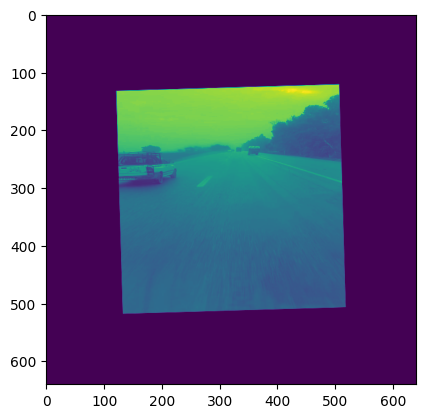

In [17]:


data_path = "/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.tensorflow/train"
# os.mkdir('/rotation')
# os.mkdir('/brightened')
# os.mkdir('/darkened')

augmentation = iaa.Sequential([
    #randomly flip horizontaly
    iaa.Fliplr(.5),
    #randomly translate left & right, up & down to simulate cropped pictures
    #rotation and scaling to simulate near and far cars
    iaa.Affine(translate_percent={"x": (0, 0), "y":(0,0)},
               rotate=(-20,20),
               scale=(0.5,1.5)),
    #randomly increase or decrease brightness
    iaa.Multiply((0.2,1.7)),
    #randomly bluring pictures for out of focus cars or really fast cars
    iaa.Sometimes(0.2,
                 iaa.GaussianBlur((0.0, 3.0)))
    
])



# folderlen = len(data_path)
for img in glob.glob(data_path+"/*.jpg"):
    image = cv.imread(img)
    augmented_images = augmentation(image=image)
    gray_images = cv.cvtColor(augmented_images, cv.COLOR_BGR2GRAY)
    normalized_images = cv.normalize(
    gray_images, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
    height, width = image.shape[:2]
    plt.imshow(normalized_images)

In [18]:
def non_max_surpression(prediction,probability_thresh,iou_thresh,box="corners"):
    assert type(bbox)==list
    bboxes = [box for box in bbboxes if box[1] > prob_threshold]
    bboxes = sorted (bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []
    

In [19]:
def separator(input_list):
    matrix=[]
    label=[]
    for tupl in input_list:
        matrix.append(np.array(tupl[0]))
        label.append(np.array(tupl[1]))
    return matrix,label
        
        
    

In [27]:
def model1():
    model = keras.Sequential([
        layers.Conv2D(32,(3,3),padding="same",use_bias="false",kernel_initializer="RandomNormal"),
        layers.Conv2D(16,(3,3),padding="same",use_bias="false",kernel_initializer="RandomNormal"),
        layers.Conv2D(4,(3,3),padding="same",use_bias="false",kernel_initializer="RandomNormal"),
        layers.Conv2D(16,(3,3),padding="same",use_bias="false",kernel_initializer="RandomNormal"),
        layers.Conv2D(4,(3,3),padding="same",use_bias="false",kernel_initializer="RandomNormal"),
        layers.Conv2D(16,(3,3),padding="same",use_bias="false",kernel_initializer="RandomNormal"),
        layers.Conv2D(4,(3,3),padding="same",use_bias="false",kernel_initializer="RandomNormal"),
        layers.Conv2D(16,(3,3),padding="same",use_bias="false",kernel_initializer="RandomNormal"),
        layers.Conv2D(4,(1,1),padding="same",use_bias="true",kernel_initializer="RandomNormal"),
        layers.MaxPool2D((7,7)),
        layers.Flatten(),
        layers.Dense(256, activation=LeakyReLU(alpha=0.01), name="layer1"),
        layers.Dropout(0.2),
        layers.Dense(256, activation=LeakyReLU(alpha=0.01), name="layer2"),
        layers.Dropout(0.2),
        layers.Dense(256,activation=LeakyReLU(alpha=0.01), name="layer3"),
        layers.Dropout(0.1),
        layers.Dense(128, activation="relu", name="layer4"),
        layers.Dropout(0.1),
        layers.Dense(128,activation=LeakyReLU(alpha=0.01), name="layer5"),
        layers.Dense(128,activation=LeakyReLU(alpha=0.01), name="layer32"),
        layers.Dropout(0.1),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(128,activation=LeakyReLU(alpha=0.01)),
        layers.Dropout(0.1),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(64,activation=LeakyReLU(alpha=0.01)),
        layers.Dense(32,activation=LeakyReLU(alpha=0.01)),
        layers.Dropout(0.1),
        layers.Dense(32, activation="sigmoid"),
        layers.Dropout(0.1),
        layers.Dense(16,activation="sigmoid" ),
        layers.Dropout(0.5),
        layers.Dense(16,activation="relu", name="layer6"),
        layers.Dense(8,activation="relu", name="layer7"),
        layers.Dense(5,activation="sigmoid",name="output"),
        layers.Reshape((5,1))
    ]
    )
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    
    
    return model
    
    
    

In [21]:
train_data=preprocessing("/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.tensorflow/train/","/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.tensorflow/train/_annotations.csv")
print("pre_test_donr")
validation_data=preprocessing("/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.tensorflow/valid","/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.tensorflow/valid/_annotations.csv")
print("pre_val_donr")
test_data=preprocessing("/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.tensorflow/test/","/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.tensorflow/test/_annotations.csv")
print("test pre done")
print("train")
train_data=train_data+validation_data

X_train,y_train=separator(train_data)


X_test,y_test=separator(test_data)


num_folds = 5  
shuffle_data = True  

# Configure KFold
kfold = KFold(n_splits=num_folds, shuffle=shuffle_data)


# Cross-validation loop
fold_no = 1
scores = [] 
x_fold_train=[]
x_fold_val=[]
y_fold_train[]

for train_index, val_index in kfold.split(X_train):  # Here, we use X_train for splitting

  # Select training and validation data from the main training set (X_train)
  print(type(train_index))
  print(train_index)
  print("train_index")
    for i in train_index:
        x_fold_train.append(X_train[i])
    for i in val_index:
        x_fold_val.append(X_train[i])
        
  #X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
  #y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

  # Create a new model instance for each fold (optional)
  model = create_model()

  # Train the model on the training data for this fold
  model.fit(X_fold_train, y_fold_train, epochs=128, batch_size=32)
  test_loss, test_acc = model.evaluate(X_test, y_test)
  scores.append(test_acc)
  model_weights = model.get_weights()
  with open(f'fold_{fold_no}_weights.h5', 'wb') as f:
    pickle.dump(model_weights, f)
  model.save_weights(model_weights_path)
  print(f'Fold {fold_no} - Test Accuracy: {test_acc:.4f}')
  fold_no += 1
print('Average Test Accuracy:', np.mean(scores))
output(scores)


    

SyntaxError: invalid syntax (712435962.py, line 28)

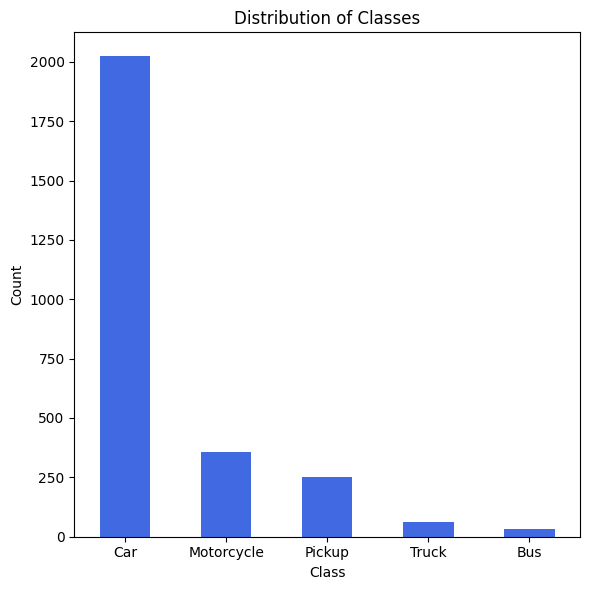

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


5448
pre_test_donr


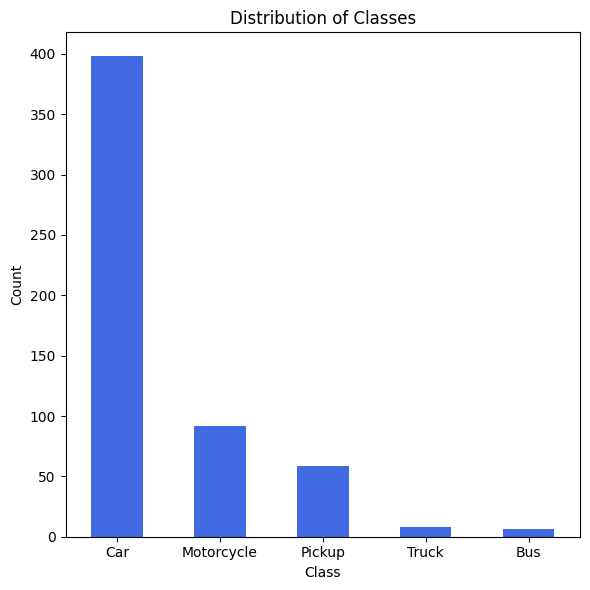

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[ WARN:0@1949.953] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.tensorflow/validframe_9613_jpg.rf.0552848f846e37a254caeafb236a4180.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1949.954] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.tensorflow/validframe_1007_jpg.rf.0cbfce7666ca0c0b40922863f0b9484c.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1949.954] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detec

0
pre_val_donr


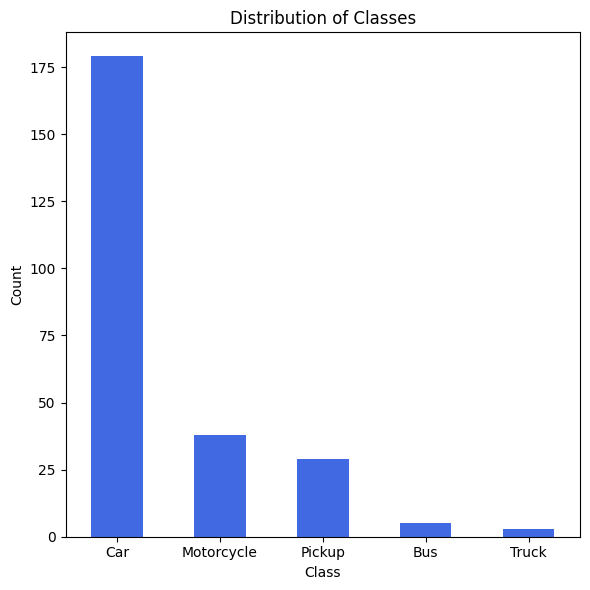

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


508
test pre done
train


/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer4 (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer5 (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer32 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/128


/opt/conda/lib/python3.10/site-packages/keras/src/losses/losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 5, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


  3/171 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.8479 - loss: 2.3842e-08   

W0000 00:00:1716369142.270976     199 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


171/171 ━━━━━━━━━━━━━━━━━━━━ 54s 156ms/step - accuracy: 0.8442 - loss: 2.3842e-08
Epoch 2/128
  3/171 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.8458 - loss: 2.3842e-08

W0000 00:00:1716369168.740008     199 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8437 - loss: 2.3842e-08
Epoch 3/128
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8459 - loss: 2.3842e-08
Epoch 4/128
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8512 - loss: 2.3842e-08
Epoch 5/128
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8452 - loss: 2.3842e-08
Epoch 6/128
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8458 - loss: 2.3842e-08
Epoch 7/128
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8446 - loss: 2.3842e-08
Epoch 8/128
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8449 - loss: 2.3842e-08
Epoch 9/128
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8449 - loss: 2.3842e-08
Epoch 10/128
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8496 - loss: 2.3842e-08
Epoch 11/128
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8433 - loss: 2.3842e-08
Epoch 12/128
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8444 - loss: 2.3842e-

W0000 00:00:1716369853.821996     199 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8834 - loss: 2.3842e-08


W0000 00:00:1716369854.622942     200 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 125, 125, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 125, 125, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 125, 125, 4)    │           580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 125, 125, 16)   │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 125, 125, 4)    │           580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 125, 125, 16)   │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 125, 125, 4)    │           580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 125, 125, 16)   │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 125, 125, 4)    │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1156)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 256)            │       296,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer4 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer5 (Dense)                  │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer32 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,51

 Total params: 1,655,345 (6.31 MB)

 Trainable params: 551,781 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,103,564 (4.21 MB)

None
loss and acuracy: 2.3841863594498136e-08 0.8818897604942322


In [28]:
train_data=preprocessing("/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.tensorflow/train/","/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.tensorflow/train/_annotations.csv")
print("pre_test_donr")
validation_data=preprocessing("/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.tensorflow/valid","/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.tensorflow/valid/_annotations.csv")
print("pre_val_donr")
test_data=preprocessing("/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.tensorflow/test/","/kaggle/input/vehicle-detection-image-dataset/Apply_Grayscale/Apply_Grayscale/Vehicles_Detection.v9i.tensorflow/test/_annotations.csv")
print("test pre done")
print("train")
train_data=train_data+validation_data

X_train,y_train=separator(train_data)
#print(type(X_train))


model = model1()
print(model.summary())

X_test,y_test=separator(test_data)
model.fit(np.array(X_train), np.array(y_train), epochs=128, batch_size=32)
test_loss, test_acc = model.evaluate(np.array(X_test), np.array(y_test))
print(model.summary())
print('loss and acuracy:', test_loss,test_acc)


In [ ]:
def output(scores):
    plt.scatter(range(len(scores)), data_list)  # x-axis: data point index, y-axis: data value

# Customize plot (optional)
    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.grid(True)  # Add grid lines for better readability

    # Display the plot
    plt.show()